In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('new_fraud2 detection.csv')

In [72]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


0    4855513
1       8213
Name: isFraud, dtype: int64


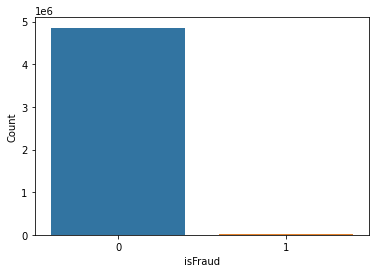

In [73]:
#CHECKING DATASET IF IMBALANCE.

print(df.isFraud.value_counts())
sns.countplot(data=df, x='isFraud')
plt.ylabel('Count')
plt.show()


Text(0.5, 1.0, 'Distribution of Time/Step')

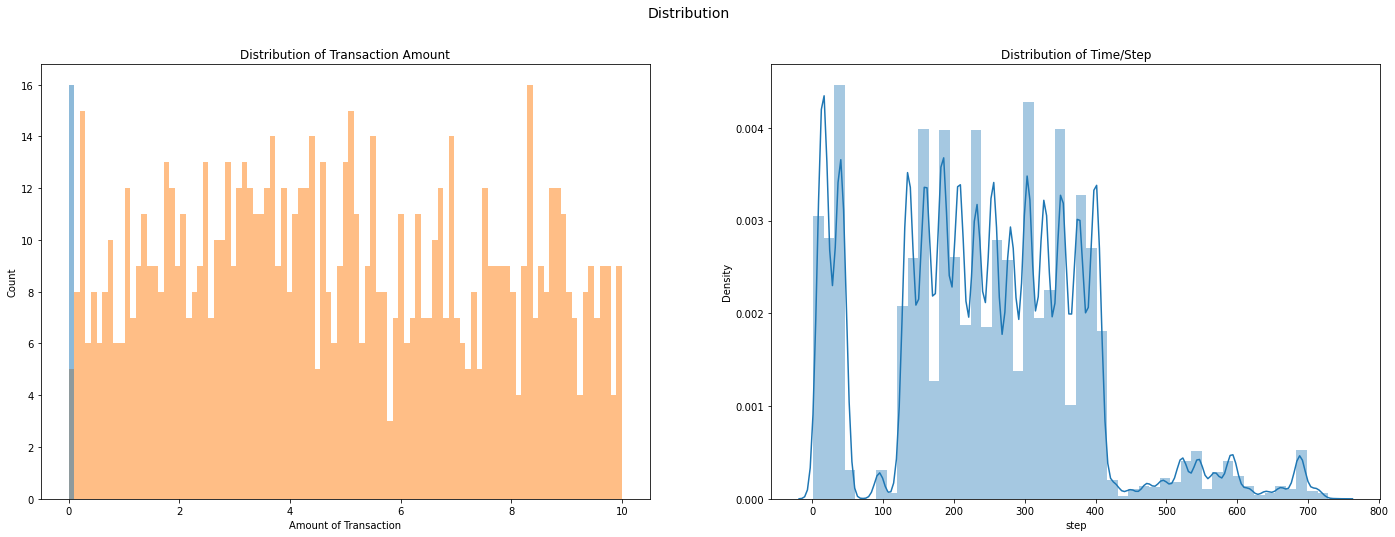

In [74]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))

# labels = ['No Fraud', 'Fraud']
f.suptitle('Distribution', fontsize=14)


#Distribution of Transaction Amount

bins = np.linspace(0, 10, 100)

data_nf = df[df['isFraud']==0]
data_f = df[df['isFraud']==1]

ax1.hist(data_nf['amount'],bins=bins, label='Non-Fraud',alpha=0.5,color='tab:orange')
ax1.hist(data_f['amount'],bins=bins,label='Fraud', alpha=0.5, color='tab:blue')

ax1.set_xlabel('Amount of Transaction')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Transaction Amount')


#Distribution of Time
ax2=sns.distplot(df['step'])
ax2.set_title('Distribution of Time/Step')

# SCALING

In [75]:
dataset = df.copy()

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaling = scaler.fit_transform(np.array(dataset['step']).reshape(-1, 1))
scaling2 = scaler.fit_transform(np.array(dataset['amount']).reshape(-1, 1))

In [77]:
dataset['step']=scaling
dataset['amount']=scaling2

<h3>Transform the categorical features into numerical.</h3>

In [78]:
dataset["type"] = dataset["type"].map({"CASH_OUT": 1, "PAYMENT": 2, 
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})

# See The Correlation 

In [80]:
#Determine the X and y
X = dataset.drop('isFraud', axis=1)
y = dataset['isFraud']

from collections import Counter
from imblearn.combine import SMOTETomek

#Implementing the technique
smk = SMOTETomek(random_state=42)

# fit and apply the transform
X_smk, y_smk = smk.fit_resample(X, y)

# summarize class distribution
print(Counter(y))
print(Counter(y_smk))

Counter({0: 4855513, 1: 8213})
Counter({0: 4842482, 1: 4842482})


In [11]:
#Make a train set dataframe for SMOTE
df_smote = X_smk
df_smote['isFraud']=y_smk

#Reset the index
df_smote['index']=[i for i in range(len(df_smote))]
df_smote = df_smote.set_index('index')

X_smk = X_smk.drop(['index','isFraud'],axis=1)


Text(0.5, 1.0, 'Fraud Distribution')

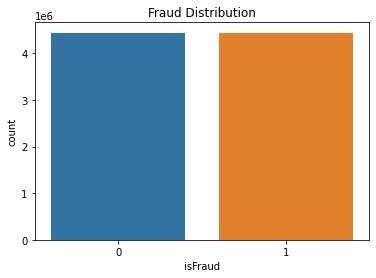

In [12]:
#Plotting the difference betweeen fraud and non-fraud transactions
sns.countplot(df_smote['isFraud'])
plt.title('Fraud Distribution')


Text(0.5, 1.0, 'After SMOTE')

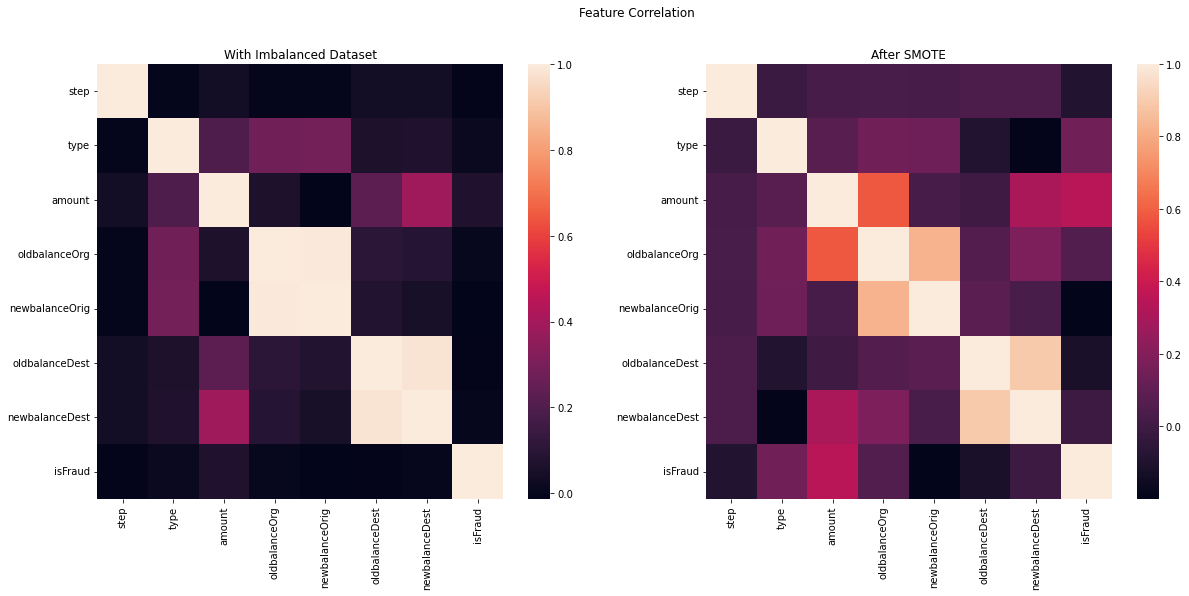

In [13]:
#Plot a heatmap
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,8))
fig.suptitle('Feature Correlation')

#Imbalanced Dataset
sns.heatmap(dataset.corr(),ax=axes[0])
axes[0].set_title('With Imbalanced Dataset')

#Data after SMOTE
sns.heatmap(df_smote.corr(),ax=axes[1])
axes[1].set_title('After SMOTE')



IndexError: single positional indexer is out-of-bounds

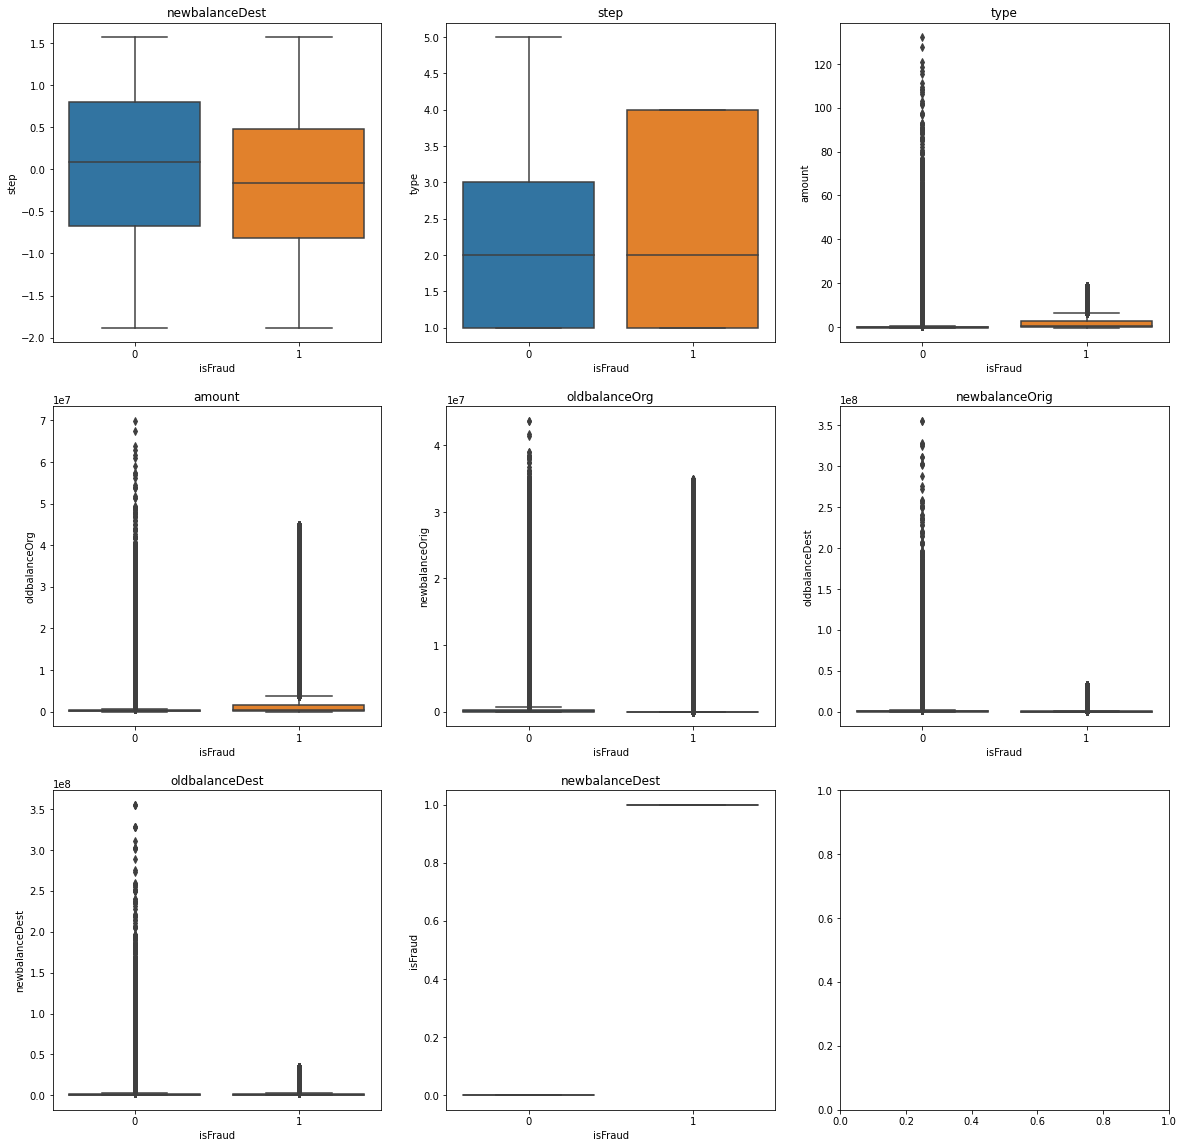

In [14]:
col = [i for i in df_smote.columns if i!='isFraud']

n_rows = 3
n_cols = 3
count = 0
col_num = 0

plt.subplots(n_rows, n_cols, figsize=(20,20))

for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, count+1)
        sns.boxplot(y=df_smote.iloc[:, col_num],x=df_smote["isFraud"])
        plt.title(col[col_num-1])
        if col_num < df.shape[1] :
            count += 1
            col_num += 1

plt.show()


In [81]:
#Removing outliers
out = ['step', 'amount']

new_df = df_smote.copy()

for i in out:
    fraud = new_df[i].loc[new_df['isFraud'] == 1].values
    q25, q75 = np.percentile(fraud, 25), np.percentile(fraud, 75)

    iqr = q75 - q25

    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    outliers = [x for x in fraud if x < lower or x > upper]

    #Drop outliers from dataset
    new_df = new_df.drop(new_df[(new_df[i] > upper) | (new_df[i] < lower)].index)



Text(0.5, 1.0, 'After')

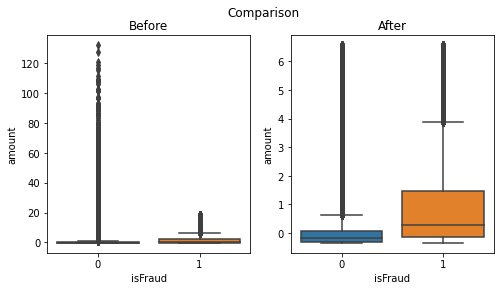

In [16]:
#Compare dataset
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8,4))
fig.suptitle('Comparison')

sns.boxplot(x="isFraud", y='amount', data=df_smote,ax=axes[0])
axes[0].set_title('Before')

sns.boxplot(x="isFraud", y='amount', data=new_df,ax=axes[1])
axes[1].set_title('After')



Text(0.5, 1.0, 'Fraud Distribution')

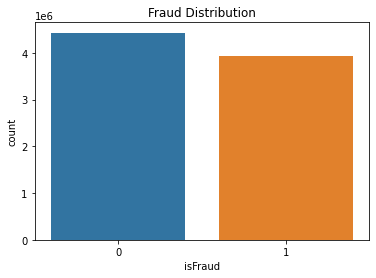

In [17]:
#Plotting the difference betweeen fraud and non-fraud transactions
sns.countplot(new_df['isFraud'])
plt.title('Fraud Distribution')



In [18]:
print('**Before Removing Outliers**')
print('Non-Fraud Transaction:',df_smote['isFraud'].value_counts()[0])
print('Fraud Transaction:',df_smote['isFraud'].value_counts()[1])
print(' ')
print('**After Removing Outliers**')
print('Non-Fraud Transaction:',new_df['isFraud'].value_counts()[0])
print('Fraud Transaction:',new_df['isFraud'].value_counts()[1])
print(' ')
print('**Reduce Number**')
print('Non-Fraud Transaction:',df_smote['isFraud'].value_counts()[0]-new_df['isFraud'].value_counts()[0])
print('Fraud Transaction:',df_smote['isFraud'].value_counts()[1]-new_df['isFraud'].value_counts()[1])

**Before Removing Outliers**
Non-Fraud Transaction: 4440799
Fraud Transaction: 4440799
 
**After Removing Outliers**
Non-Fraud Transaction: 4431318
Fraud Transaction: 3924125
 
**Reduce Number**
Non-Fraud Transaction: 9481
Fraud Transaction: 516674


# Dataset Random Under-Sampling

In [19]:
# import the library
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_us, y_us = undersample.fit_resample(X, y)

# summarize class distribution
print(Counter(y))
print(Counter(y_us))

Counter({0: 4449529, 1: 4503})
Counter({0: 4503, 1: 4503})


In [20]:
#Make a train set dataframe for random under sampling
df_us = X_us
df_us['isFraud']=y_us

#Reset the index
df_us['index']=[i for i in range(len(df_us))]
df_us = df_us.set_index('index')

X_us = X_us.drop(['index','isFraud'],axis=1)




Analyze each Dataset

Here I will compare these dataset to find which technique fits the best for this imbalanced dataset:

1. Random Under Sampling
2. SMOTE
3. SMOTE + Outliers
4. Original Dataset



In [21]:
datas = {'Random-Under-Sampling': df_us, 'SMOTE' : df_smote,'SMOTE+Outliers' : new_df, 'Ori Dataset':dataset}

precision_recall_score={}
crossval_score={}
class_report={}
accuracyscore={} 
f1score={}
rocauc_score={}


<h2>Precision-Recall Curve<h2>

In [22]:
# precision-recall curve and f1
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

f1={}
aucscore={}
recall={}
precision={}

for i in range(len(datas)):
    #Split dataset
    X = (list(datas.values())[i]).drop('isFraud', axis=1)
    y = (list(datas.values())[i])['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state = 42)

    # Turn the values into an array for feeding the classification algorithms.
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    
    #fit into a model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)

    # predict probabilities
    lr_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # predict class values
    yhat = model.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

    # summarize scores
    recall[list(datas.keys())[i]]=lr_recall
    precision[list(datas.keys())[i]]=lr_precision
    
    f1[list(datas.keys())[i]]=f1_score(y_test, yhat)
    aucscore[list(datas.keys())[i]]=auc(lr_recall, lr_precision)

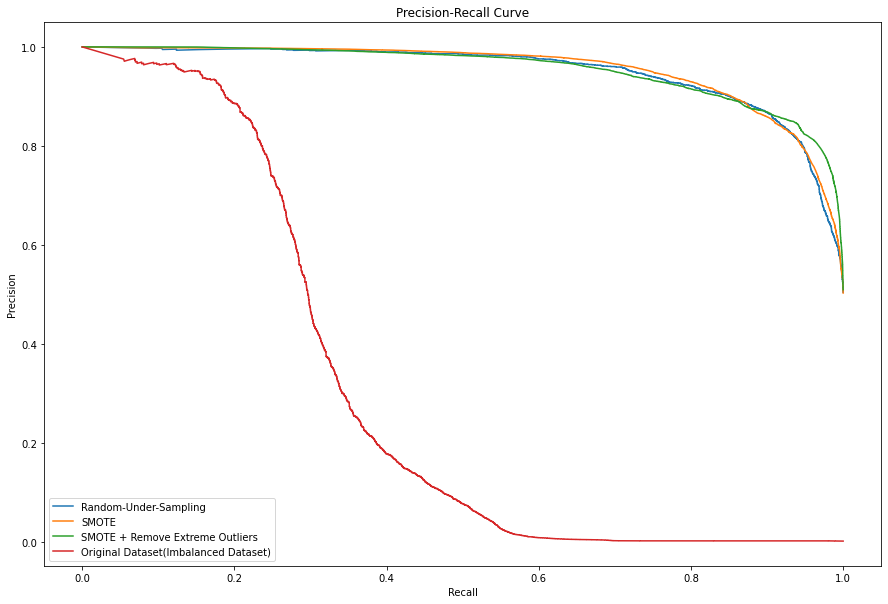

In [23]:


# plot the precision-recall curves 
plt.plot(list(recall.values())[0], list(precision.values())[0],  label=list(recall.keys())[0])
plt.plot(list(recall.values())[1], list(precision.values())[1],  label=list(recall.keys())[1])
plt.plot(list(recall.values())[2], list(precision.values())[2],  label='SMOTE + Remove Extreme Outliers')
plt.plot(list(recall.values())[3], list(precision.values())[3],  label='Original Dataset(Imbalanced Dataset)')

# axis labels
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the legend
plt.legend()

# show the plot
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()



<h2>ROC-AUC Curve<h2>

In [24]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc2={}
fpr={}
tpr={}

for i in range(len(datas)):
    #Split dataset
    X = (list(datas.values())[i]).drop('isFraud', axis=1)
    y = (list(datas.values())[i])['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state = 42)

    # Turn the values into an array for feeding the classification algorithms.
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    
    #fit into a model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)

    # predict probabilities
    lr_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # calculate scores
    lr_auc = roc_auc_score(y_test, lr_probs)
    
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    
    auc2[list(datas.keys())[i]]=lr_auc
    fpr[list(datas.keys())[i]]=lr_fpr
    tpr[list(datas.keys())[i]]=lr_tpr

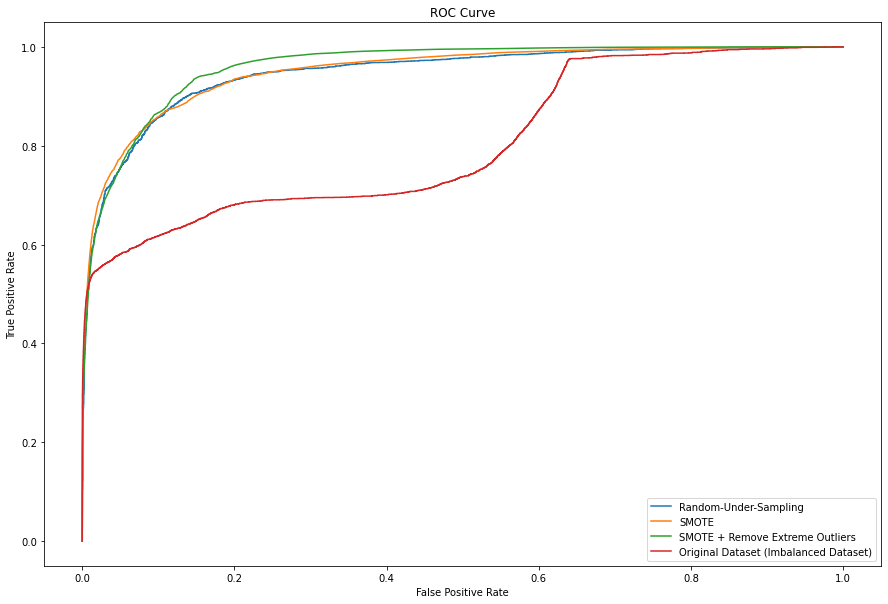

In [25]:
# plot the roc curve for the model
plt.plot(list(fpr.values())[0], list(tpr.values())[0],  label=list(tpr.keys())[0])
plt.plot(list(fpr.values())[1], list(tpr.values())[1],  label=list(tpr.keys())[1])
plt.plot(list(fpr.values())[2], list(tpr.values())[2],  label='SMOTE + Remove Extreme Outliers')
plt.plot(list(fpr.values())[3], list(tpr.values())[3],  label='Original Dataset (Imbalanced Dataset)')

# axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)

# show the plot
plt.show()

In [56]:
new_df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
index,,,,,,,,
0,-1.884438,2,-0.325809,170136.0,160296.36,0.0,0.0,0
1,-1.884438,2,-0.340936,21249.0,19384.72,0.0,0.0,0
2,-1.884438,4,-0.344129,181.0,0.00,0.0,0.0,1
3,-1.884438,1,-0.344129,181.0,0.00,21182.0,0.0,1
4,-1.884438,2,-0.322341,41554.0,29885.86,0.0,0.0,0


In [58]:
new_df.to_csv('model_smote.csv', index=False)